# **Import lib**

In [92]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Dropout, Flatten, Dense
from keras.optimizers import Adam
import os, numpy as np, matplotlib.pyplot as plt, json, cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random, shutil

import time
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix


# **Split file**

In [93]:
# Đường dẫn 
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_base = "/kaggle/working/BTXRD_data"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [95]:
# Tạo thư mục lưu ảnh mới
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Tính số lượng ảnh cho mỗi tập
total = len(image_files)
train_split = int(0.7 * total)
test_split = int(0.2 * total)

# Chia danh sách ảnh
train_files = image_files[:train_split]
test_files = image_files[train_split:train_split + test_split]
valid_files = image_files[train_split + test_split:]

# Hàm di chuyển ảnh và annotation tương ứng
def move_files(files, dest_folder):
    for file in files:
        # Di chuyển ảnh
        shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

        # Di chuyển file annotation nếu có
        annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
        if os.path.exists(os.path.join(annotation_dir, annotation_file)):
            shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# Di chuyển các tập dữ liệu
move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(valid_files, valid_dir)

print(f"Đã chia {total} ảnh thành:")
print(f"- Train: {len(train_files)} ảnh")
print(f"- Test: {len(test_files)} ảnh")
print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


# **SegNet**

In [97]:
n_classes = 2     # normal, tumor
img_h = img_w = 96

In [98]:
# Đường dẫn dữ liệu
data_dir = '/kaggle/input/btxrd-v2/'
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "Annotations")
valid_images_dir = os.path.join(data_dir, "valid", "images")
valid_annotations_dir = os.path.join(data_dir, "valid", "Annotations")


In [99]:
def load_data(images_dir, annotations_dir):
    images, labels = [], []
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        annotation_path = os.path.join(annotations_dir, os.path.splitext(img_file)[0] + '.json')

        # Đọc ảnh grayscale và resize
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_h, img_w))

        # Mặc định không có khối u (0)
        label = 0  
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                annotation_data = json.load(f)
            if "shapes" in annotation_data and len(annotation_data["shapes"]) > 0:
                label = 1  # Có khối u

        images.append(img)
        labels.append(label)

    # Chuẩn hóa dữ liệu
    images = np.array(images, dtype=np.float32) / 255.0
    images = np.expand_dims(images, axis=-1)  # Thêm kênh để phù hợp với CNN
    labels = to_categorical(labels, num_classes=n_classes)

    return images, labels



In [100]:
x_train, y_train = load_data(train_images_dir, train_annotations_dir)
x_valid, y_valid = load_data(valid_images_dir, valid_annotations_dir)

In [101]:
# Kiểm tra số lượng mẫu trong tập train và validation
print(f"Số lượng ảnh trong tập train: {len(x_train)}")
print(f"Số lượng ảnh trong tập validation: {len(x_valid)}")

# Kiểm tra kích thước ảnh
print(f"Kích thước ảnh trong tập train: {x_train.shape}")
print(f"Kích thước ảnh trong tập validation: {x_valid.shape}")

# Kiểm tra nhãn
print(f"Số lượng nhãn (train): {np.bincount(np.argmax(y_train, axis=1))}")
print(f"Số lượng nhãn (validation): {np.bincount(np.argmax(y_valid, axis=1))}")


Số lượng ảnh trong tập train: 2622
Số lượng ảnh trong tập validation: 375
Kích thước ảnh trong tập train: (2622, 96, 96, 1)
Kích thước ảnh trong tập validation: (375, 96, 96, 1)
Số lượng nhãn (train): [1306 1316]
Số lượng nhãn (validation): [187 188]


In [102]:
# Định nghĩa CNN
input_image = Input(shape=(img_h, img_w, 1), name='Input')

x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output_label = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output_label, name='btxrd_cnn')


In [103]:
# In mô hình
model.summary()

Model: "btxrd_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 96, 96, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 94, 94, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 47, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,979,970 (121.99 MB)

 Trainable params: 31,979,970 (121.99 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# Data Augmentation (Chỉ áp dụng cho tập train)
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

In [105]:
# Xây dựng mô hình CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(img_h, img_w, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Giảm overfitting

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(n_classes, activation='softmax')
])

In [106]:
starting_time = time.time()

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train mô hình với Data Augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    validation_data=(x_valid, y_valid),
                    epochs=50,
                    callbacks=[early_stopping])
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.5245 - loss: 0.9583 - val_accuracy: 0.6053 - val_loss: 0.7933
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5706 - loss: 0.7716 - val_accuracy: 0.6133 - val_loss: 0.7273
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5949 - loss: 0.7328 - val_accuracy: 0.6773 - val_loss: 0.6822
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6340 - loss: 0.7039 - val_accuracy: 0.6667 - val_loss: 0.6891
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6446 - loss: 0.6848 - val_accuracy: 0.6507 - val_loss: 0.6887
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6547 - loss: 0.6758 - val_accuracy: 0.6507 - val_loss: 0.6671
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6280 - loss: 0.6863 - val_accuracy: 0.6667 - val_loss: 0.6564
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6468 - loss: 0.6698 - val_accuracy: 0.6827 -

In [107]:
# Tải dữ liệu từ thư mục validation
x_valid, y_true = load_data(valid_images_dir, valid_annotations_dir)

# Dự đoán nhãn
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Tính toán Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report (F1-score, Precision, Recall)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Tumor"]))


Confusion Matrix:
 [[137  50]
 [ 55 133]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.71      0.73      0.72       187
       Tumor       0.73      0.71      0.72       188

    accuracy                           0.72       375
   macro avg       0.72      0.72      0.72       375
weighted avg       0.72      0.72      0.72       375



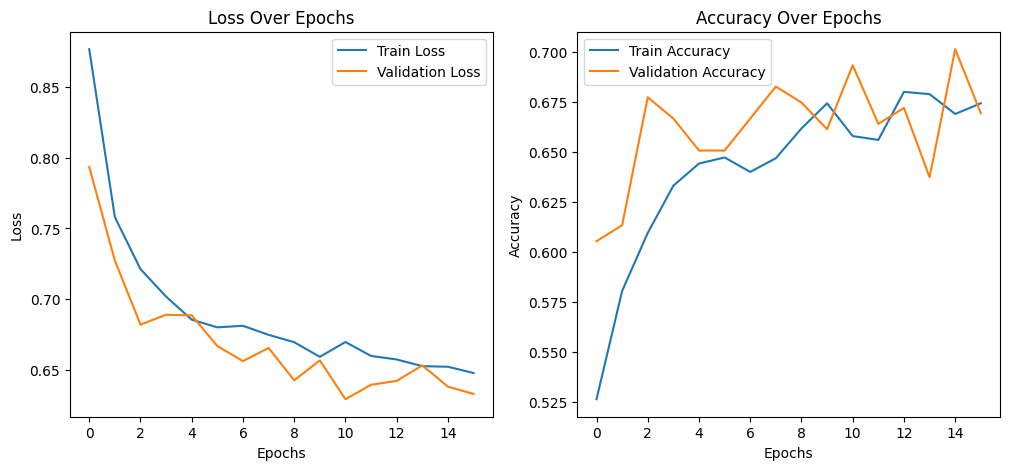

In [108]:
# Vẽ biểu đồ Loss & Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [109]:
# Đánh giá trên tập test
test_images_dir = os.path.join(data_dir, "test", "images")
test_annotations_dir = os.path.join(data_dir, "test", "Annotations")
x_test, y_test = load_data(test_images_dir, test_annotations_dir)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7087 - loss: 0.6204
Test accuracy: 0.6916, Test loss: 0.6245


khúc này trở xuống chưa chạy đc

In [110]:
# kiểm tra một ảnh đơn lẻ
# này đang lỗi (chưa nhận diện được khối u)

def predict_single_image(image_path, model):
    # Đọc và xử lý ảnh giống như trong load_data
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension (1, img_h, img_w, 1)
    
    # Dự đoán
    prediction = model.predict(img)
    
    # Kết quả
    class_idx = np.argmax(prediction)  # Chọn lớp có xác suất cao nhất
    if class_idx == 1:
        print("Ảnh này có khả năng chứa khối u / ung thư.")
    else:
        print("Ảnh này không có khối u / ung thư.")
    
    return prediction

# Chạy thử một ảnh
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000005.jpeg'
predict_single_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Ảnh này không có khối u / ung thư.


array([[0.7133482, 0.2866518]], dtype=float32)

In [ ]:
# Dự đoán trên một ảnh X-ray
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w)) / 255.0
    img = np.expand_dims(img, axis=[0, -1])

    pred = model.predict(img)
    class_pred = np.argmax(pred)
    label = "Normal" if class_pred == 0 else "Tumor"

    plt.imshow(img.reshape(img_h, img_w), cmap='gray')
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()

In [ ]:
import json

def predict_image(image_path, annotations_dir):
    img_name = os.path.splitext(os.path.basename(image_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.json')

    # Đọc ảnh và tiền xử lý
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w)) / 255.0
    img = np.expand_dims(img, axis=[0, -1])

    # Dự đoán bằng mô hình CNN
    pred = model.predict(img)
    class_pred = np.argmax(pred)
    label = "Normal" if class_pred == 0 else "Tumor"

    # Kiểm tra nếu có annotation để tính diện tích khối u
    tumor_area = 0
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            annotation_data = json.load(f)

        # Giả sử annotation_data chứa danh sách điểm tạo thành polygon vùng u
        if "shapes" in annotation_data:
            for shape in annotation_data["shapes"]:
                if shape["label"] == "tumor":
                    points = shape["points"]  # Danh sách tọa độ [x, y]
                    contour = np.array(points, dtype=np.int32)

                    # Tính diện tích của khối u
                    tumor_area = cv2.contourArea(contour)

    print(f"Ảnh: {img_name}")
    print(f"Nhận diện mô hình: {label}")
    if tumor_area > 0:
        print(f"Diện tích khối u: {tumor_area:.2f} pixels")

    # Hiển thị ảnh
    plt.imshow(img.reshape(img_h, img_w), cmap='gray')
    plt.title(f'Predicted: {label} (Tumor Area: {tumor_area:.2f})' if tumor_area > 0 else f'Predicted: {label}')
    plt.axis('off')
    plt.show()


In [ ]:
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000004.jpeg'
predict_image(test_image_path, test_annotations_dir)


In [ ]:
# Dự đoán trên một ảnh X-ray
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w)) / 255.0
    img = np.expand_dims(img, axis=[0, -1])  # Thêm batch và channel

    pred = model.predict(img)
    class_pred = np.argmax(pred)
    label = "Normal" if class_pred == 0 else "Tumor"

    plt.imshow(img.reshape(img_h, img_w), cmap='gray')
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()

# Thử nghiệm với một ảnh trong tập test
test_image_path = os.path.join(test_dir, 'tumor', 'sample.png')
predict_image(test_image_path)